In [13]:
from utils import read_csv_data, clean_location, build_column_vocabulary, convert_to_one_hot, cat_emb

In [31]:
# Change to Categorical
data = read_csv_data("../data/processed_job_postings_large_noNA.csv", 
                     ["industry", "work_type", "location", "formatted_experience_level", "title_emb"], "salary_level")
data = clean_location(data, 2)

import random
random.seed(70)
random.shuffle(data)

train_data = data[:10000]
val_data = data[10000:13000]
test_data = data[13000:]

In [32]:
vocab_sector = build_column_vocabulary(train_data, 0)
vocab_type = build_column_vocabulary(train_data, 1)
vocab_state = build_column_vocabulary(train_data, 2)
vocab_level = build_column_vocabulary(train_data, 3)
len(vocab_type)

7

In [38]:
import torch
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

targets = [data[i][1] for i in range(len(data))]

labels = ['10K-'] + [f"{i}K - {i + 10}K" for i in range(10, 150, 10)] + ['160K+']
label_to_int = {label: i for i, label in enumerate(labels)}

targets = list(map(lambda x: label_to_int[x], targets))

targets = torch.tensor(targets)

train_targets = targets[:10000]
val_targets = targets[10000:13000]
test_targets = targets[13000:]

In [39]:
train_targets

tensor([15,  3,  6,  ...,  3,  3,  8])

In [48]:
# Attempt with basic MLP

from mlp import MLPDataset
# temp looks like this
# [[Tensor1, Tensor2, Tensor3, Tensor4], ...]
temp = convert_to_one_hot(train_data, 
                          [(0, vocab_sector),
                           (1, vocab_type),
                           (2, vocab_state),
                           (3, vocab_level)])
train_one_hot = MLPDataset(temp, [target.type(torch.LongTensor) for target in train_targets])



temp = convert_to_one_hot(val_data, 
                          [(0, vocab_sector),
                           (1, vocab_type),
                           (2, vocab_state),
                           (3, vocab_level)])
val_one_hot = MLPDataset(temp, [target.type(torch.LongTensor) for target in val_targets])

In [49]:
from mlp import MLP, train_classifier
total_features = train_one_hot[0][0].shape[0]
model = MLP(input_size=total_features, hidden_size=1000, output_size=len(labels))  

Iter 50: Loss: 2.6752920150756836 Train mae 0.1443, Validation mae 0.15166666666666667
Iter 100: Loss: 2.6596410274505615 Train mae 0.1529, Validation mae 0.16066666666666668
Iter 150: Loss: 2.623894691467285 Train mae 0.2146, Validation mae 0.219
Iter 200: Loss: 2.485123634338379 Train mae 0.215, Validation mae 0.219
Iter 250: Loss: 2.4665355682373047 Train mae 0.2323, Validation mae 0.22833333333333333
Iter 300: Loss: 2.247488021850586 Train mae 0.233, Validation mae 0.22966666666666666
Iter 350: Loss: 2.360109806060791 Train mae 0.236, Validation mae 0.23066666666666666
Iter 400: Loss: 2.3850293159484863 Train mae 0.237, Validation mae 0.235
Iter 450: Loss: 2.3534743785858154 Train mae 0.232, Validation mae 0.231
Iter 500: Loss: 2.257676601409912 Train mae 0.232, Validation mae 0.23266666666666666
Iter 550: Loss: 2.154961347579956 Train mae 0.2369, Validation mae 0.233
Iter 600: Loss: 2.3096933364868164 Train mae 0.2439, Validation mae 0.23566666666666666
Iter 650: Loss: 2.404913902

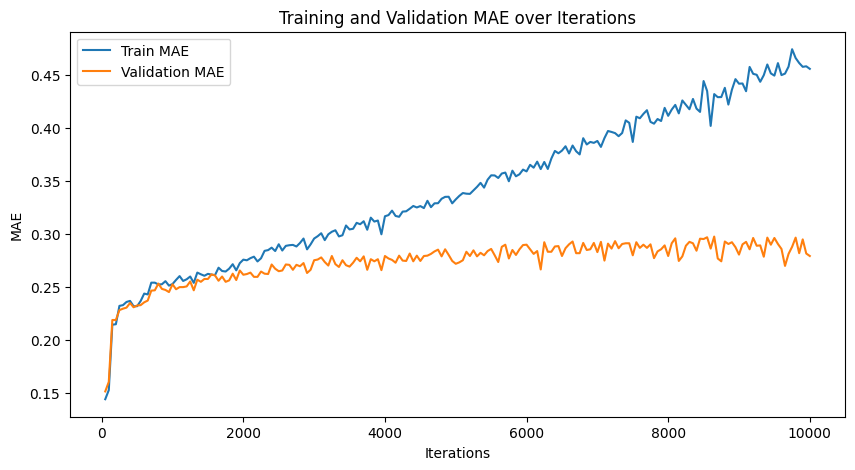

In [50]:
train_classifier(model, train_one_hot, val_one_hot, 0.1, batch_size=100, num_epochs=100)

In [52]:
# Attempt to add topic embedding to improve the model

from mlp import MLPDataset
# temp looks like this
# [[Tensor1, Tensor2, Tensor3, Tensor4], ...]
temp = convert_to_one_hot(train_data, 
                          [(0, vocab_sector),
                           (1, vocab_type),
                           (2, vocab_state),
                           (3, vocab_level)])
temp = cat_emb(temp, train_data, 4)
train_one_hot_with_emb = MLPDataset(temp, [target.type(torch.LongTensor) for target in train_targets])

temp = convert_to_one_hot(val_data, 
                          [(0, vocab_sector),
                           (1, vocab_type),
                           (2, vocab_state),
                           (3, vocab_level)])
temp = cat_emb(temp, val_data, 4)
val_one_hot_with_emb = MLPDataset(temp, [target.type(torch.LongTensor) for target in val_targets])

In [53]:
from mlp import MLP, train_classifier
total_features = train_one_hot_with_emb[0][0].shape[0]
model2 = MLP(input_size=total_features, hidden_size=1000, output_size=len(labels))  

Iter 50: Loss: 2.634195327758789 Train mae 0.1443, Validation mae 0.15166666666666667
Iter 100: Loss: 2.5537424087524414 Train mae 0.1443, Validation mae 0.15166666666666667
Iter 150: Loss: 2.5176503658294678 Train mae 0.2134, Validation mae 0.221
Iter 200: Loss: 2.497525215148926 Train mae 0.2178, Validation mae 0.224
Iter 250: Loss: 2.39132022857666 Train mae 0.2231, Validation mae 0.22666666666666666
Iter 300: Loss: 2.380551815032959 Train mae 0.2274, Validation mae 0.23266666666666666
Iter 350: Loss: 2.258002281188965 Train mae 0.2318, Validation mae 0.23766666666666666
Iter 400: Loss: 2.355705976486206 Train mae 0.2537, Validation mae 0.25566666666666665
Iter 450: Loss: 2.0407118797302246 Train mae 0.257, Validation mae 0.25866666666666666
Iter 500: Loss: 2.1880545616149902 Train mae 0.264, Validation mae 0.26466666666666666
Iter 550: Loss: 2.1578493118286133 Train mae 0.2756, Validation mae 0.2776666666666667
Iter 600: Loss: 2.215528964996338 Train mae 0.2788, Validation mae 0.27

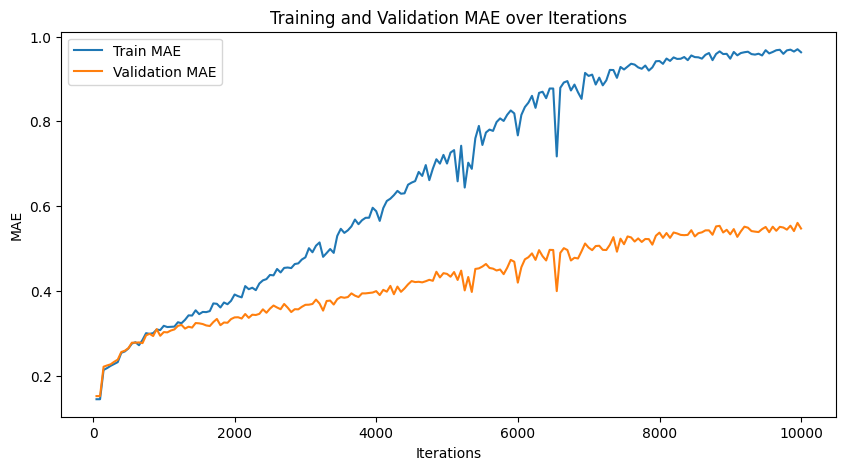

In [54]:
train_classifier(model2, train_one_hot_with_emb, val_one_hot_with_emb, 0.1, batch_size=100, num_epochs=100)

In [56]:
from utils import accuracy

temp = convert_to_one_hot(test_data, 
                          [(0, vocab_sector),
                           (1, vocab_type),
                           (2, vocab_state),
                           (3, vocab_level)])
temp = cat_emb(temp, test_data, 4)
test_one_hot_with_emb = MLPDataset(temp, [target.type(torch.LongTensor) for target in test_targets])

accuracy(model2, test_one_hot_with_emb)

0.5863192182410424